## Dependencies for using Sagemaker

In [1]:
!pip install -qq sagemaker-huggingface-inference-toolkit 
# !pip install -qq transformers==4.6.1 "datasets[s3]"
# !pip install -qq ipywidgets
# !pip install -qq watermark 
# !pip install -qq "seaborn>=0.11.0"


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker 2.72.1 requires boto3>=1.20.18, but you have boto3 1.16.43 which is incompatible.
awscli 1.22.25 requires botocore==1.23.25, but you have botocore 1.19.52 which is incompatible.
awscli 1.22.25 requires s3transfer<0.6.0,>=0.5.0, but you have s3transfer 0.3.7 which is incompatible.


In [52]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [53]:
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import ProfilerConfig, DebuggerHookConfig, Rule, ProfilerRule, rule_configs
import sagemaker.huggingface
from sagemaker.huggingface import HuggingFace
import transformers
from transformers import AutoTokenizer
from datasets import load_dataset


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from textwrap import wrap

import boto3
import pprint
import time

## declare the sagemaker session
We have to get the role, S3 location before we can start working with sagemaker

In [54]:
sess = sagemaker.Session()
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::596849958460:role/service-role/AmazonSageMaker-ExecutionRole-20220209T230020
sagemaker bucket: sagemaker-ap-southeast-1-596849958460
sagemaker session region: ap-southeast-1


## Data
We are using the imdb data from https://huggingface.co/datasets/imdb.
The data set has 25K training example and 25K testing example about the positive and negative reviews

The data is downloaded and stored locally for the subsequent runs

In [55]:
dataset_name = 'imdb'

train_dataset, test_dataset = load_dataset(dataset_name, split=['train', 'test'])
train_dataset = train_dataset.shuffle().select(range(5000))  ## for the demo purpose restricting it to 5000. else the trainign will take a long time
test_dataset = test_dataset.shuffle().select(range(5000))

Reusing dataset imdb (/home/ec2-user/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)
Loading cached shuffled indices for dataset at /home/ec2-user/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-1e5861303163a7d7.arrow
Loading cached shuffled indices for dataset at /home/ec2-user/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-b397d9a489b571a6.arrow


In [56]:
print(train_dataset.column_names)

['text', 'label']


In [57]:
train_dataset.shape

(5000, 2)

### the +ve and -ve labels are equally distributed 

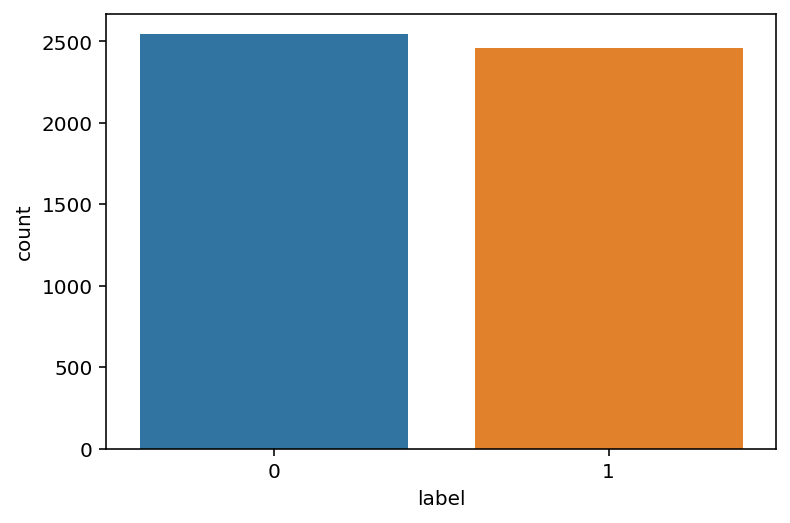

In [58]:
sns.countplot(x=train_dataset['label'])
plt.xlabel('label');

## Model 
We are using the **distilbert-base-cased** model for fine tuning. 

In [59]:
tokenizer_name = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

In [60]:
# Helper function to get the content to tokenize
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# Tokenize
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

# Set the format to PyTorch
train_dataset = train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Loading cached processed dataset at /home/ec2-user/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-b922c2cc95d99fd7.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

### uploading the tokenised trainign and testing datasets to S3

In [61]:
import botocore
from datasets.filesystems import S3FileSystem

# Upload to S3
s3 = S3FileSystem()
s3_prefix = f'samples/datasets/{dataset_name}'
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path,fs=s3)
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path,fs=s3)

print(f'Uploaded training data to {training_input_path}')
print(f'Uploaded testing data to {test_input_path}')

Uploaded training data to s3://sagemaker-ap-southeast-1-596849958460/samples/datasets/imdb/train
Uploaded testing data to s3://sagemaker-ap-southeast-1-596849958460/samples/datasets/imdb/test


### giving a name to the finetuned model

In [62]:
model_name = 'distilbert-base-cased'
import datetime
ct = datetime.datetime.now() 
current_time = str(ct.now()).replace(":", "-").replace(" ", "-")[:19]
training_job_name=f'finetune-{model_name}-{current_time}'
print( training_job_name )

finetune-distilbert-base-cased-2022-02-18-18-49-27


### hyperparamters that will be passed to the train script

In [63]:
hyperparameters={'epochs': 3,
                 'train_batch_size': 32,
                 'model_name': model_name,
                 'tokenizer_name': tokenizer_name,
                 'output_dir':'/opt/ml/checkpoints',
                 }

## dunmp of the training script. 
Essentially it is using the trainier from hugging face that provides the loop for the trianing and eval

In [48]:
!pygmentize ./scripts/train.py

"""
Training script for Hugging Face SageMaker Estimator
"""
import logging
import sys
import argparse
import os
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, TrainingArguments
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train_batch_size", type=int, default=32)
    parser.add_argument("--eval_batch_size", type=int, default=64)
    parser.add_argument("--warmup_steps", type=int, default=500)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--tokenizer_name", type=str)
    parser.add_argument("--learning_rate", type=str, default=5e-5)

    # Data, model, and output directories
    parser.add_

### definition of the metrics that we want to capture during the trainign

In [64]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}]

### Definign the Estimator
this is the most important step where we are defining the estimator. This is essentially configuring the training script to run with our dataset

In [65]:
huggingface_estimator = HuggingFace(entry_point='train.py', ## the training script
                            source_dir='./scripts', ## the directory for the trainign script
                            instance_type='ml.p3.2xlarge', ## trianing resource
                            instance_count=1, ## how many such instances
                            role=role, ## permisssions
                            transformers_version='4.6', 
                            pytorch_version='1.7',
                            py_version='py36',
                            hyperparameters = hyperparameters, ## passing the hyperparameters
                            metric_definitions=metric_definitions, ## metrics to be calculated
                            max_run=36000, # expected max run in seconds
                        )

In [66]:
huggingface_estimator.fit(
    {'train': training_input_path, 'test': test_input_path}, 
    wait=False, 
    job_name=training_job_name )

In [ ]:
sess.wait_for_job(training_job_name)


2022-02-18 18:50:05 Starting - Starting the training job......
2022-02-18 18:50:40 Starting - Preparing the instances for training...........
2022-02-18 18:51:41 Downloading - Downloading input data...
2022-02-18 18:52:02 Training - Downloading the training image.........................................
2022-02-18 18:55:30 Training - Training image download completed. Training in progress..............................................................................
2022-02-18 19:02:07 Uploading - Uploading generated training model........
2022-02-18 19:02:53 Completed - Training job completed


{'TrainingJobName': 'finetune-distilbert-base-cased-2022-02-18-18-49-27',
 'TrainingJobArn': 'arn:aws:sagemaker:ap-southeast-1:596849958460:training-job/finetune-distilbert-base-cased-2022-02-18-18-49-27',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-ap-southeast-1-596849958460/finetune-distilbert-base-cased-2022-02-18-18-49-27/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'epochs': '3',
  'model_name': '"distilbert-base-cased"',
  'output_dir': '"/opt/ml/checkpoints"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"finetune-distilbert-base-cased-2022-02-18-18-49-27"',
  'sagemaker_program': '"train.py"',
  'sagemaker_region': '"ap-southeast-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-ap-southeast-1-596849958460/finetune-distilbert-base-cased-2022-02-18-18-49-27/source/sourcedir.tar.gz"',
  'tokenizer_name': '"distilbert-base-cased"',
  'train_batch_size': '32'},
 'AlgorithmSpecif

### displaying the metrics

In [68]:
from sagemaker import TrainingJobAnalytics

# Captured metrics can be accessed as a Pandas dataframe
df = TrainingJobAnalytics(training_job_name=training_job_name).dataframe()
df.head(10)

,timestamp,metric_name,value
0,0.0,eval_loss,0.365952
1,120.0,eval_loss,0.323193
2,240.0,eval_loss,0.373089
3,0.0,eval_accuracy,0.839800
4,120.0,eval_accuracy,0.865800
5,240.0,eval_accuracy,0.879200
6,0.0,eval_f1,0.852296
7,120.0,eval_f1,0.872748
8,240.0,eval_f1,0.871544
9,0.0,eval_precision,0.779164


### graphs to visualize the metrics

<AxesSubplot:label='1c85ec8d-ada5-407e-aeae-2721ab34cb3c', xlabel='timestamp', ylabel='value'>

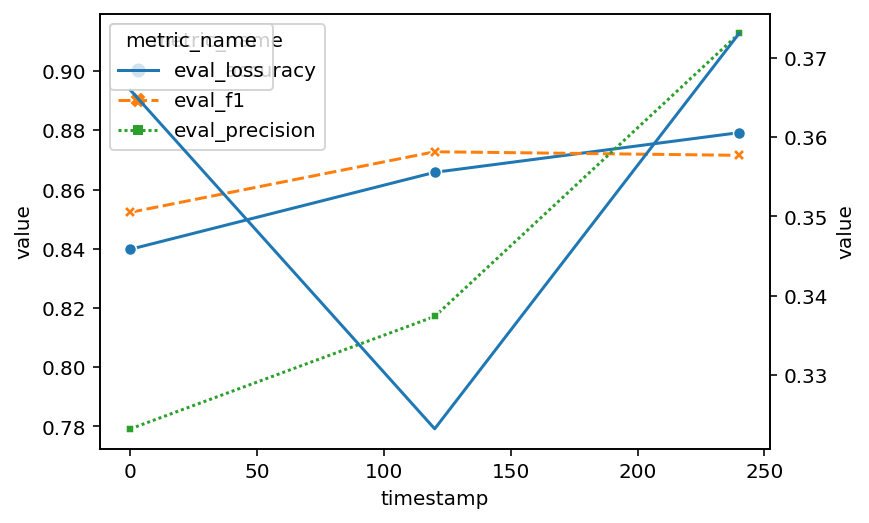

In [69]:
evals = df[df.metric_name.isin(['eval_accuracy','eval_precision', 'eval_f1'])]
losses = df[df.metric_name.isin(['loss', 'eval_loss'])]

sns.lineplot(
    x='timestamp', 
    y='value', 
    data=evals, 
    style='metric_name',
    markers=True,
    hue='metric_name'
)

ax2 = plt.twinx()
sns.lineplot(
    x='timestamp', 
    y='value', 
    data=losses, 
    hue='metric_name',
    ax=ax2)

### After training, we use the PyTorch estimator to build and deploy a PyTorchPredictor. This creates a Sagemaker Endpoint -- a hosted prediction service that we can use to perform inference

In [70]:
predictor = huggingface_estimator.deploy(
    initial_instance_count=1, 
    instance_type="ml.m5.xlarge", 
    endpoint_name=training_job_name
)

-----!

### examples for inference

In [74]:
data = {
   "inputs": [
       "I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn't match the background, and painfully one-dimensional characters cannot be overcome with a 'sci-fi' setting. (I'm sure there are those of you out there who think Babylon 5 is good sci-fi TV. It's not. It's clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It's really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it's rubbish as they have to always say sd Earth... otherwise people would not continue watching. Roddenberry's ashes must be turning in their orbit as this dull, cheap, poorly edited (watching it without advert breaks really brings this home) trudging Trabant of a show lumbers into space. Spoiler. So, kill off a main character. And then bring him back as another actor. Jeeez! Dallas all over again.", 
       "i did not like the movie",
       "i liked the movie for the story , but the action was very bad"
   ]
}

# request
predictor.predict(data)

[{'label': 'LABEL_0', 'score': 0.9945787787437439},
 {'label': 'LABEL_0', 'score': 0.8286938667297363},
 {'label': 'LABEL_0', 'score': 0.9906011819839478}]

## delete the endpoint

In [75]:
predictor.delete_endpoint()